In [49]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

lit = pd.read_csv("data/reaxys/literature_reactions.tsv", delimiter="\t")


def smi2numpyarr(smi: str) -> np.ndarray:
    """Generate a fingerprint numpy array from a SMILES string."""
    fpgen = rdFingerprintGenerator.GetMorganGenerator()

    mol = Chem.MolFromSmiles(smi)
    fp = fpgen.GetFingerprintAsNumPy(mol)
    return fp


X = np.array([smi2numpyarr(smi) for smi in lit["product_1_smiles"]])

In [50]:
from rdkit.Chem import DataStructs
from rdkit.ML.Cluster import Butina


def tanimoto_distance_matrix(fp_list: list) -> list:
    """Calculate distance matrix for fingerprint list."""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix


def cluster_fingerprints(fingerprints: list, cutoff=0.2) -> list:
    """Cluster fingerprints using the Taylor-Butina algorithm."""
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)

    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters


In [61]:
X_fp = [DataStructs.CreateFromBitString("".join(x.astype(str).tolist())) for x in X]

clusters = cluster_fingerprints(X_fp, cutoff=0.5)

<BarContainer object of 2870 artists>

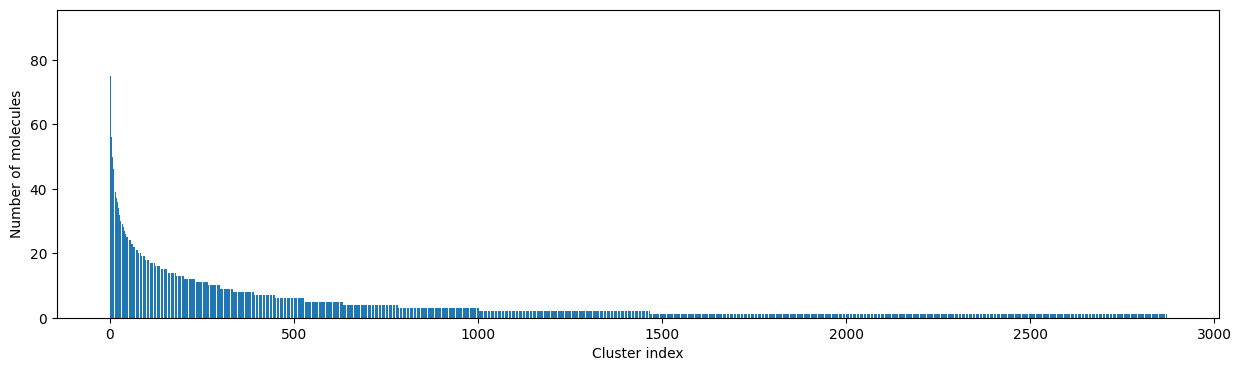

In [62]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

In [63]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  2870
# clusters with only 1 compound:  1402
# clusters with >5 compounds:  528
# clusters with >25 compounds:  45
# clusters with >100 compounds:  0


In [68]:
mols = [Chem.MolFromSmiles(smi) for smi in lit.product_1_smiles.to_list()]

Cluster 900 size:  3


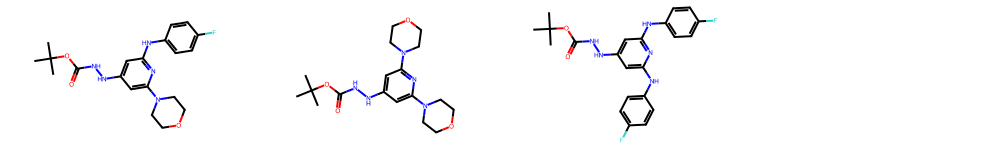

In [129]:
from rdkit.Chem import Draw

cluster = 900

print(f"Cluster {cluster} size: ", len(clusters[cluster]))
Draw.MolsToGridImage(
    [mols[i] for i in clusters[cluster]][:12],
    molsPerRow=4,
    subImgSize=(250, 150),
    useSVG=True,
)

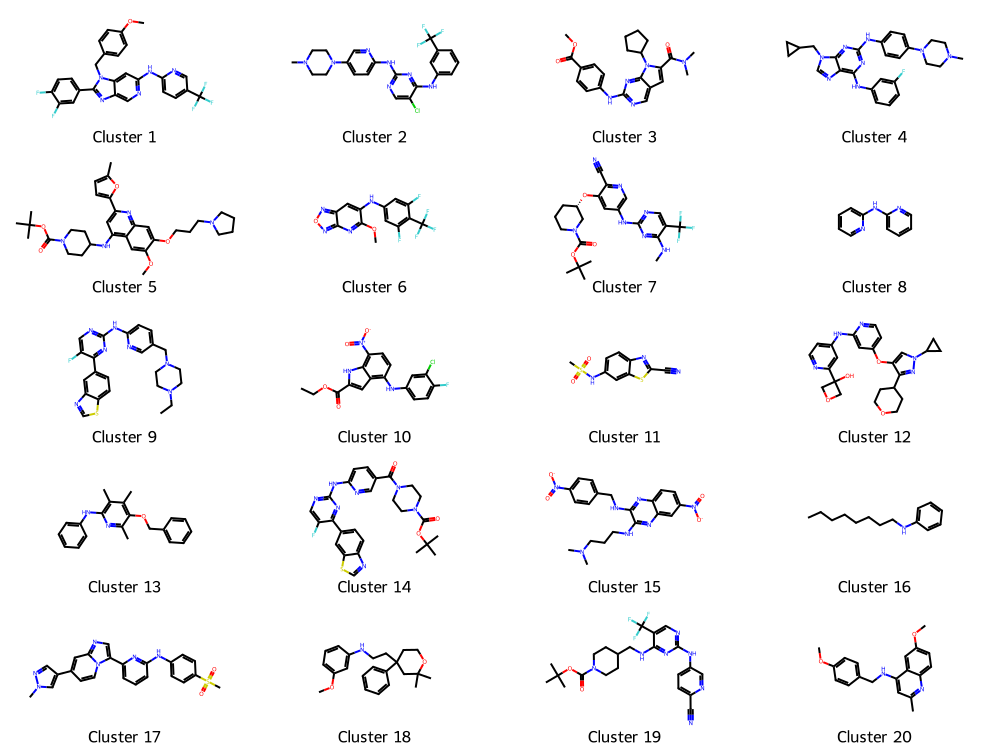

In [113]:
Draw.MolsToGridImage(
    [mols[clusters[i][0]] for i in range(20)],
    molsPerRow=4,
    subImgSize=(250, 150),
    useSVG=True,
    legends=[f"Cluster {i+1}" for i in range(20)],
)

In [128]:
cluster_heads_index = [clusters[i][0] for i in range(len(clusters))]

cluster_heads = lit.iloc[cluster_heads_index].copy()
cluster_heads["cluster"] = range(len(clusters))

cluster_heads.to_csv("data/reaxys/cluster_heads.tsv", sep="\t", index=False)